In [409]:
import salty
data = ['cpt', 'density'] #pull raw data from cpt.csv and density.csv
T = [298.1, 298.16] #select narrow state variable ranges
P = [101, 102] #we will set MD simulation to 101 kPa and 298 K
data = salty.aggregate_data(data,T=T,P=P)

In [401]:
from math import exp
def merge_duplicates(model_name):
    if model_name is str:
        model_outputs = len(model_name.split("_"))
        pickle_in = open("../salty/data/MODELS/%s_devmodel.pkl" % model_name,
                         "rb")
        devmodel = dill.load(pickle_in)
    else:
        model_outputs = -6 + model_name.Data_summary.shape[0]
        devmodel = model_name
        
    cols = devmodel.Data.columns
    if (devmodel.Data.iloc[:,-(4+model_outputs):-4].max() < 700).all():
        for output_index in range(model_outputs):
            devmodel.Data.iloc[:, -(5+output_index)] = \
            devmodel.Data.iloc[:, -(5+output_index)].apply(lambda x: exp(float(x)))
    output_val = []
    output_xtd = []
    running_size = []
    for output_index in range(model_outputs):
        output_val.append(devmodel.Data.groupby(['smiles-cation', 'smiles-anion']
                         )[cols[-(5+output_index)]].mean())
        output_xtd.append(devmodel.Data.groupby(['smiles-cation', 'smiles-anion']
                         )[cols[-(5+output_index)]].std())
        running_size.append(devmodel.Data.groupby(['smiles-cation', 'smiles-anion']
                         )[cols[-(5+output_index)]].count())
    salts = (devmodel.Data["smiles-cation"]+"."
             +devmodel.Data["smiles-anion"]).unique() #grab the unique salts
    size = np.sum(running_size)
    return output_val, output_xtd, size, salts, devmodel

In [402]:
vals, stds, size, salts, devmodel = merge_duplicates(data)

In [410]:
data.Data.shape

(1622, 196)

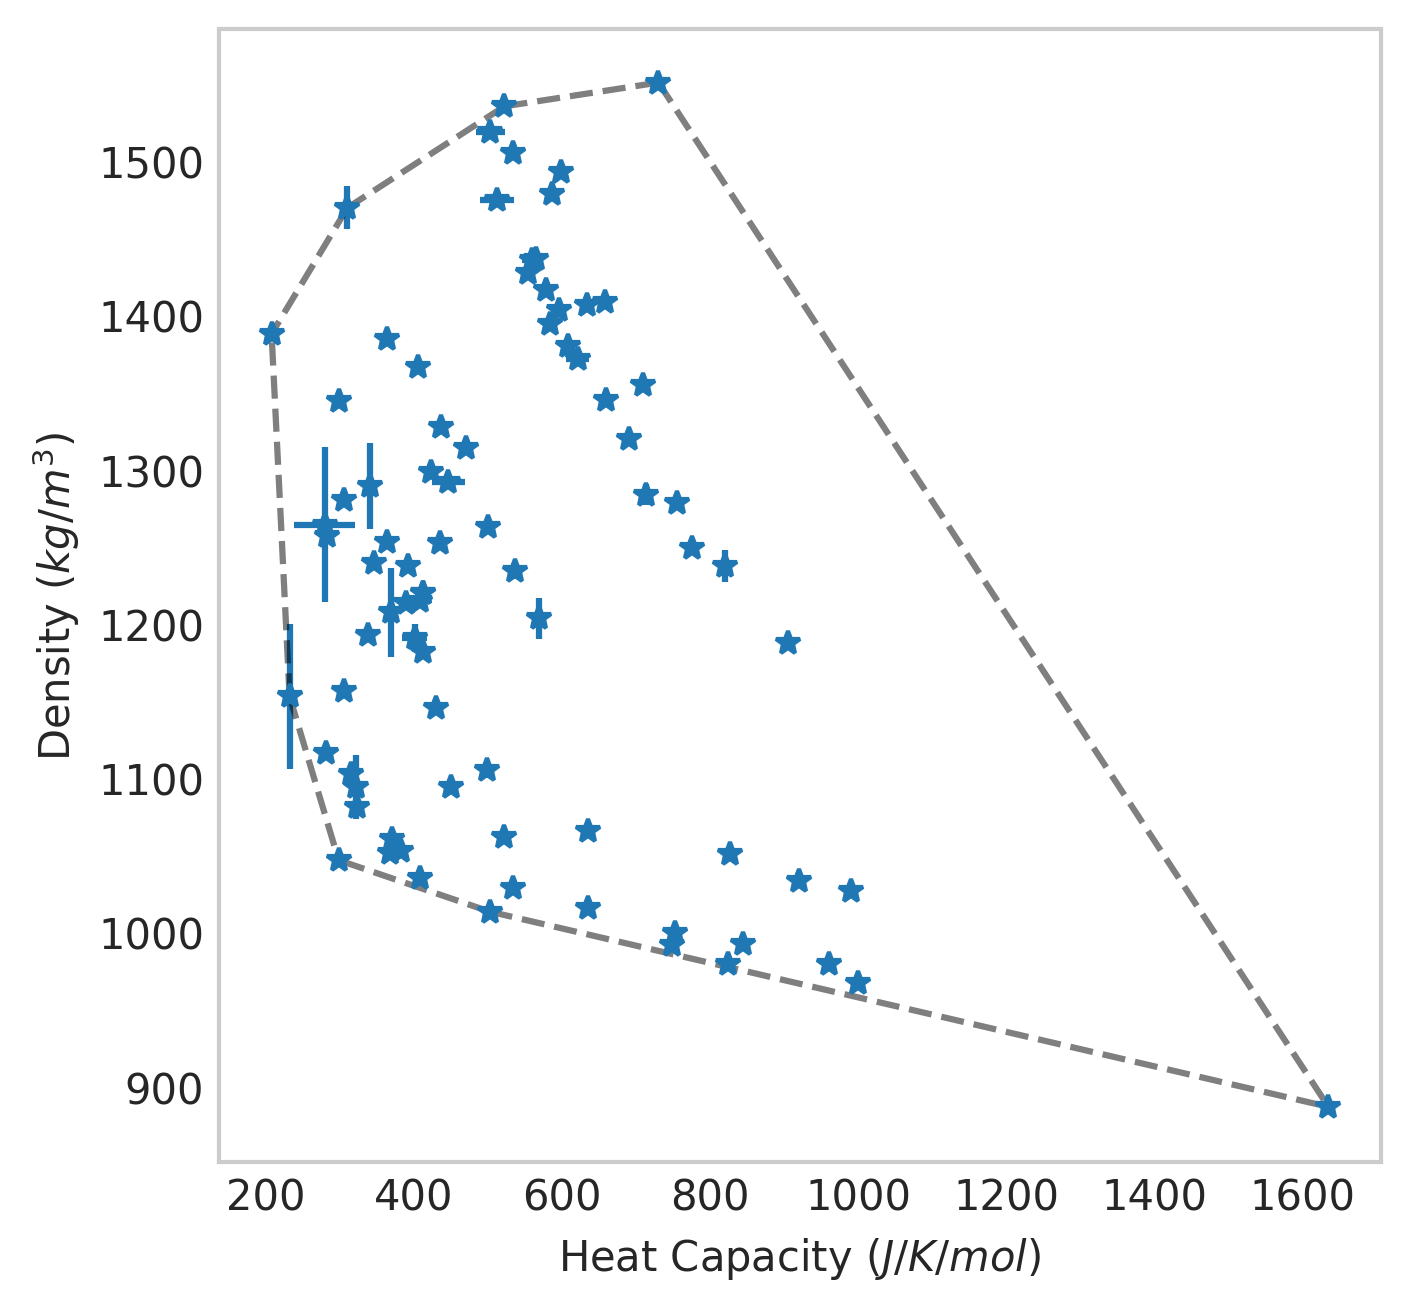

In [403]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
dataDf = pd.DataFrame([np.reshape(vals[1].values,(82)),
                       np.reshape(vals[0].values,(82))])
dataDf = dataDf.T
hull = ConvexHull(dataDf)
%matplotlib inline
df = devmodel.Data
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(5,5), dpi=300)
    ax=fig.add_subplot(111)
    scat = ax.errorbar(vals[1], vals[0], xerr=stds[1], 
                       yerr=stds[0],
        marker="*", linestyle="")
    for simplex in hull.simplices:
        ax.plot(dataDf.iloc[simplex, 0], dataDf.iloc[simplex, 1], 'k-',
               alpha=0.5, linestyle="--")
    ax.grid()
    ax.set_ylabel("Density $(kg/m^3)$")
    ax.set_xlabel("Heat Capacity $(J/K/mol)$")

In [317]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

fig, ax = plt.subplots(figsize=(10,10),subplot_kw=dict(facecolor='white'))
N = len(x)

scatter = ax.scatter(xval,
                     yval,
                     s=100+100*np.log(size),
                     c=np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.set_ylabel("Density (kg/m3)")
ax.set_xlabel("Heat Capacity (J/K/mol)")
ax.grid(color='white', linestyle='solid')

labels = ['{}  {}'.format(salty.check_name(salts[i].split(".")[0]),
                        salty.check_name(salts[i].split(".")[1])) 
                         for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()